# Report ( 모비딕 )

## curaition 아이디어 소개

>저희 팀은 고객뿐만 아니라 증권회사에게도 이익이 될 수 있는 curation 방안을 생각했습니다.  
증권사는 고객들의 거래량이 늘어날 때 수수료를 통해서 금전적 이익을 얻습니다.  
일반적인 고객들에게 큰 수익을 내는 것보다 리스크를 잘 분배해서 손실을 얼마나 적게 보느냐가 더 중요합니다.  
양측의 이익을 위해서 저희는 '개인용 포트폴리오 curation'을 생각했습니다.
개인은 일반 펀드에서 많은 수수료를 때야지 할 수 있는 포트폴리오 운영을 저희가 추천하는 curation으로 보다 쉽게 할 수 있습니다.  
포트폴리오 curation에는 그룹화된 고객의 성향에 맞게 원자재, 주식, 채권 같은 대략적인 금융상품의 비율이 추천될 것입니다.
추천된 비율 안에서 고객이 직접 선택해서 세부적인 상품들을 채워넣을 수 있게 프레임을 제공합니다.
이를 통해 고객들은 포트폴리오를 통한 분할투자의 효과를 얻을 수 있게됩니다.  
포트폴리오의 각 요소들은 시간이 지남에 따라 그 비율이 변하고, 본래 의도했던 리스크에서 벗어날 수 있습니다.  
그때 필수적으로 포트폴리오에서는 리밸런싱이라는 작업을 해야합니다.  
금융사는 자사 포트폴리오 curaition 서비스를 이용한 고객들에게 그 비율의 표준편차가 일정정도 이상 벗어나면 리밸런싱을 자동적으로 진행해주거나 고객에게 알림을 보내서 리밸런싱을 유도할 수 있습니다.  
리밸런싱으로 하면서 발생하는 거래들의 수수료를 통해서 금융사는 그만큼의 금전적이득을 얻을 수 있습니다.  
저희 '개인용 포트폴리오 curation'은 고객과 증권사 양측이 모두 이익을 얻을 수 있는 win-win 전략입니다.  

## 표적 Data

> 포트폴리오는 단기 투자보다는 장기 투자에 최적화된 전략입니다.  
거래량이 많고 뚜렷한 철학이 있는 단기 투자자들에게 저희가 제공하는 curaition은 효용이 떨어질 것 입니다.  
장기적 투자를 하는 고객들이 포트폴리오 curaition을 했을 때 양측에게 모두 이익이 될 것이라고 판단했습니다.  
거래량과 접속량이 적은 고객들의 Data를 표적 Data로 설정하는 것을 일차적인 목표로 설정했습니다.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pandasql import sqldf
from sklearn.cluster import KMeans

In [2]:
class Data:
    def __init__(self, mts, tot, byn_sll):
        self.mts = mts
        self.tot = tot
        self.byn_sll = byn_sll

    def __str__(self):
        return 'mts : {}, tot : {}, byn_sll : {}'.format(self.mts, self.tot, self.byn_sll)

In [3]:
cus_ifo = pd.read_csv("./cus_ifo.csv", header=0, usecols=['act_no', 'mts_mm_access_type', 'tot_ivs_te_sgm_cd', 'bas_stk_trd_tp_cd', 'bse_ym'])
cus_ifo=cus_ifo.loc[cus_ifo['bse_ym']==202206] # 22년 6월 info 정보만 받기

cus_itg = pd.read_csv('./cus_itg_sct_bnc.csv', header=0, usecols=['act_no', 'itg_byn_cns_qty', 'itg_sll_cns_qty'])

cus_ifo['mts_mm_access_type'] = cus_ifo['mts_mm_access_type'].astype('string')
cus_ifo['act_no'] = cus_ifo['act_no'].astype('string')
cus_itg['act_no'] = cus_itg['act_no'].astype('string')

data_mts = {}
data_tot = {}
for row_i, row in cus_ifo.iterrows():
    if row_i > 0 and str(row['bas_stk_trd_tp_cd']) != '1' and str(row['bas_stk_trd_tp_cd']) != '2' and str(row['tot_ivs_te_sgm_cd']) != '99':
        data_mts[row['act_no']] = row['mts_mm_access_type'].count('1')
        data_tot[row['act_no']] = row['tot_ivs_te_sgm_cd']

data_byn_sll = {}
for row_i, row in cus_itg.iterrows():
    if row_i > 0:
        byn = row['itg_byn_cns_qty']
        sll = row['itg_sll_cns_qty']
        if row['act_no'] in data_byn_sll:
            tmp = data_byn_sll[row['act_no']]
            data_byn_sll[row['act_no']] = tmp+byn+sll
        else:
            data_byn_sll[row['act_no']] = byn+sll
        

data_set = {}
for key in data_byn_sll:
    if key in data_mts and data_byn_sll[key] <= 10000:
        data_set[key] = Data(data_mts[key], data_tot[key], data_byn_sll[key])

In [4]:
mts_list = []
tot_list = []
byn_sll_list = []
for key in data_set.keys():
    mts_list.append(data_set[key].mts)
    tot_list.append(data_set[key].tot)
    byn_sll_list.append(data_set[key].byn_sll)

df = pd.DataFrame({'act_no':data_set.keys(), 'mts_mm_access_type':mts_list, 'tot_ivs_te_sgm_cd':tot_list, 'byn_sll':byn_sll_list})

In [5]:
df_mts=df['mts_mm_access_type'].value_counts()

In [6]:
df_mts.index

Int64Index([6, 5, 3, 4, 2, 1], dtype='int64')

In [7]:
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['font.size']=15 # 글자크기
matplotlib.rcParams['axes.unicode_minus']=False # -깨짐현상 해결

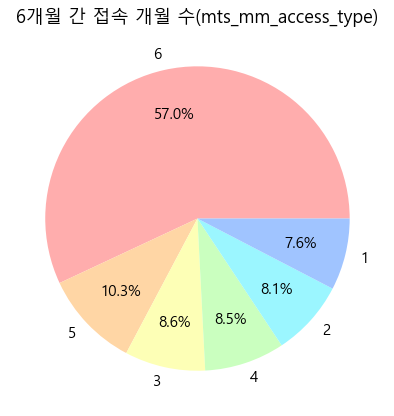

In [8]:
colors=['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff']

plt.figure(figsize=(7,7))
plt.pie(df_mts,labels=df_mts.index,autopct='%.1f%%',colors=colors,pctdistance=0.7)
plt.title('6개월 간 접속 개월 수(mts_mm_access_type)')
plt.show()

In [9]:
df_tot=df['tot_ivs_te_sgm_cd'].value_counts()
df_tot

3    4361
1    2678
2    1059
4     559
6     420
5     419
Name: tot_ivs_te_sgm_cd, dtype: int64

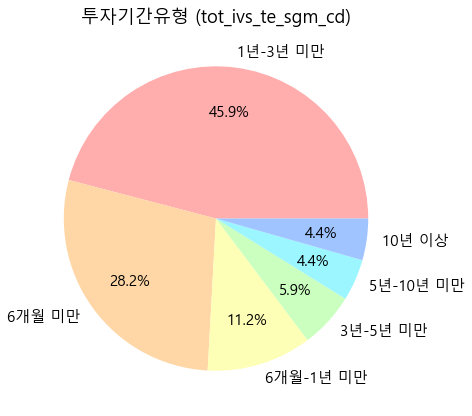

In [10]:
colors=['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff']
labels=['1년-3년 미만', '6개월 미만','6개월-1년 미만', '3년-5년 미만', '5년-10년 미만', '10년 이상']

plt.figure(figsize=(7,7))
plt.pie(df_tot,labels=labels,autopct='%.1f%%',colors=colors,pctdistance=0.7)
plt.title('투자기간유형 (tot_ivs_te_sgm_cd)')
plt.show()

In [11]:
df1=df['byn_sll'].value_counts()
df1

0.0       4345
1.0        431
2.0        287
3.0        172
4.0        112
          ... 
2927.0       1
8400.0       1
654.0        1
9426.0       1
663.0        1
Name: byn_sll, Length: 1545, dtype: int64

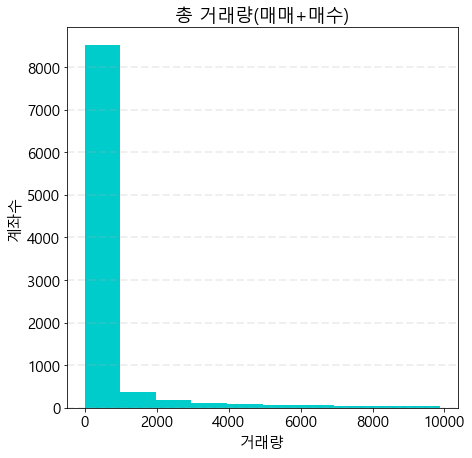

In [12]:
plt.figure(figsize=(7,7))
plt.title('총 거래량(매매+매수)')
df['byn_sll'].hist(color='#00CCCC')
plt.xlabel('거래량')
plt.ylabel('계좌수')
plt.grid(axis='y',alpha=0.2,linestyle='--',linewidth=2)
plt.grid(axis='x',alpha=0)
plt.show()

In [13]:
X_or=df.to_numpy()
X=X_or[:,1:]
X

array([[1, 1, 0.0],
       [6, 3, 0.0],
       [6, 3, 0.0],
       ...,
       [6, 3, 0.0],
       [6, 3, 7.0],
       [3, 1, 2.0]], dtype=object)

In [14]:
from sklearn.preprocessing import RobustScaler
sc = RobustScaler()
X = sc.fit_transform(X)
X

array([[-2.5       , -1.        , -0.01075269],
       [ 0.        ,  0.        , -0.01075269],
       [ 0.        ,  0.        , -0.01075269],
       ...,
       [ 0.        ,  0.        , -0.01075269],
       [ 0.        ,  0.        ,  0.06451613],
       [-1.5       , -1.        ,  0.01075269]])

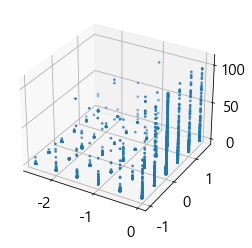

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], s=3)
plt.show()

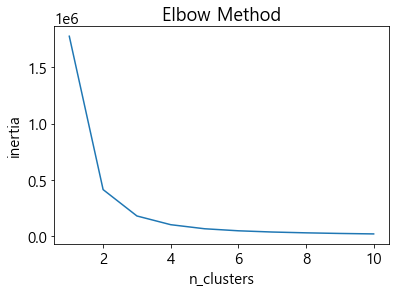

In [16]:
from sklearn.cluster import KMeans
inertia_list = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_) # 각 지점으로부터 클러스터의 중심(centroid) 까지의 거리의 제곱의 합
    
plt.plot(range(1, 11), inertia_list)
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

In [17]:
K=2

In [18]:
kmeans = KMeans(n_clusters=K, random_state=0) # default init 값이 k-means++ 라서 안적어도 상관없음.
# kmeans.fit(X)
y_kmeans = kmeans.fit_predict(X)

In [19]:
y_kmeans

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
centers = kmeans.cluster_centers_ # 클러스터의 중심점 (centroid) 좌표
centers

array([[-0.64314962, -0.21917884,  1.7133107 ],
       [-0.09347826,  0.22065217, 57.4350321 ]])

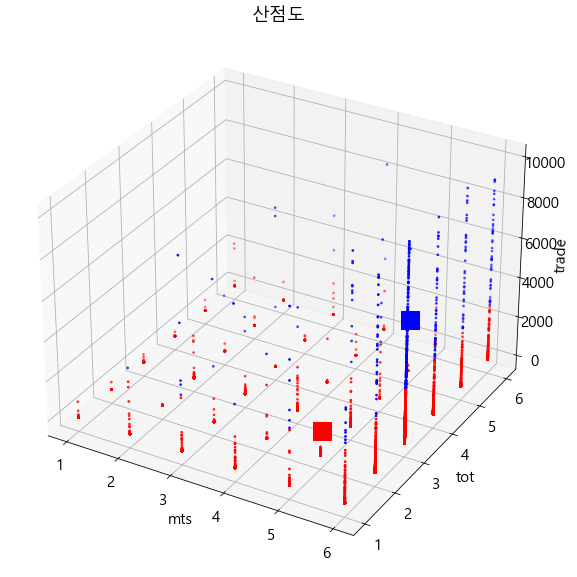

In [21]:
X_org = sc.inverse_transform(X)

centers_org = sc.inverse_transform(centers)
centers_org

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

color=['r','b']

for cluster in range(K):
    ax.scatter(X_org[y_kmeans == cluster, 0], X_org[y_kmeans == cluster, 1], X_org[y_kmeans == cluster, 2], s=3,color=color[cluster]) # 각 데이터
    ax.scatter(centers_org[cluster, 0], centers_org[cluster, 1],centers_org[cluster, 2] ,s=300, color=color[cluster], marker='s') # 중심점 네모



plt.title('산점도')
ax.set_xlabel('mts')
ax.set_ylabel('tot')
ax.set_zlabel('trade')
plt.show()

In [22]:
X_red=X_or[y_kmeans==0]
X_blue=X_or[y_kmeans==1]

In [23]:
X_red.shape

(9036, 4)

In [24]:
X_blue.shape

(460, 4)

In [25]:
X_blue[:,1]

array([6, 6, 6, 6, 6, 2, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 5,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 5, 6, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 3, 6, 6, 3, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 3, 6,
       6, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 3, 3, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5,

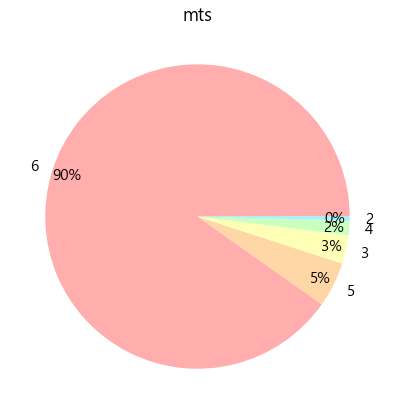

In [26]:
kk=pd.Series(X_blue[:,1])
colors=['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff']
plt.figure(figsize=(7,7))
plt.pie(kk.value_counts(),labels=kk.value_counts().index,autopct='%.0f%%',colors=colors,pctdistance=0.9)
plt.title('mts')
plt.show()

In [27]:
pd.Series(X_blue[:,0])

0      2a3aa73b2e8d2256b616d29a2edf867c7d0ad339956c47...
1      8cc956e08c2de0d3abf65905b77485de972624d4cf6433...
2      927adc141956244ab007a485634cbad4d687221405577a...
3      8b4868cba37117ebd7b9eaa67061f600739439b7b497c9...
4      0b1f36e7eecd8304d067f4492874708d72ba3791d7fc09...
                             ...                        
455    65d5d6c17256a055dc1ec75116a8351b618f959beedcea...
456    380987d11b127b727bccf270c6794acf0b4729159f880a...
457    3f44171f8564c4113c7e52e571d251db7e9c3c01fe3440...
458    5ed1d033d9273e813153ef2f62239b425726a6872485f3...
459    2ddc25eab5834401bd6561d5cc1b49c4436e2c4029c272...
Length: 460, dtype: object

In [28]:
pd.Series(X_red[:,0])

0       4c272f9facccc618a111c42576be006390ea9775407c02...
1       628426b03d25a2ae774539e19d783777cb56a4910e547e...
2       555452034340e408093f1c25b468b78935ca78eca4225a...
3       57a9de76d17175c56bb4a872ee0a6269be21f38fb0937f...
4       1b0c986dbe5004d731b1cc24b8586d1d9035cfcd459e12...
                              ...                        
9031    68c3870368bbc5e067d184ca0e8fa757717c4ae64f3e97...
9032    41cff1fb07509a7e36d5b0578abf40301d167698f3bcfb...
9033    484fde543de8e7383ee3070a4b36baea247366ba6aca13...
9034    14b6c2ef1b9f411b39bb88cc58bc11519545a2843a2046...
9035    8a302c32df0a3110af9fea8285cb720cfba9cd57b87123...
Length: 9036, dtype: object

In [29]:
cus_ifo_1 = pd.read_csv("./cus_ifo.csv", header=0, usecols=['act_no', 'sex_dit_cd', 'cus_age_stn_cd', 'cus_aet_stn_cd', 'lsg_sgm_cd', 'mrz_pdt_tp_sgm_cd','bse_ym'])
cus_ifo_1=cus_ifo_1.loc[cus_ifo_1['bse_ym']==202206]

cus_ifo_1

,act_no,bse_ym,sex_dit_cd,cus_age_stn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd
2,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,1,4,1,2,3
11,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,202206,1,7,1,2,5
13,726a3295019efd88142038b123013623e26a217d2b08df...,202206,1,5,1,2,5
23,4f2a78f9a162f9c82350f40627ce1062afaefeb4ff34e7...,202206,1,6,5,2,7
27,8010d50edbbcd1974e12cb20fbca3a3abea0088df3070e...,202206,2,4,1,2,4
...,...,...,...,...,...,...,...
59055,331ebc85b76813b4f37ace30577786f061df9b5a559644...,202206,1,8,1,2,5
59060,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,202206,1,2,1,2,2
59064,e6d3e46bc3a679c2ac46811862787bbfda4fa59acc013d...,202206,2,3,1,2,4
59073,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202206,2,5,1,2,8


In [30]:
filt_red=cus_ifo_1['act_no'].isin(pd.Series(X_red[:,0])) 
cus_ifo_red=cus_ifo_1[filt_red]

filt_blue=cus_ifo_1['act_no'].isin(pd.Series(X_blue[:,0]))
cus_ifo_blue=cus_ifo_1[filt_blue]

In [31]:
cus_ifo_red

,act_no,bse_ym,sex_dit_cd,cus_age_stn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd
2,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,1,4,1,2,3
11,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,202206,1,7,1,2,5
13,726a3295019efd88142038b123013623e26a217d2b08df...,202206,1,5,1,2,5
23,4f2a78f9a162f9c82350f40627ce1062afaefeb4ff34e7...,202206,1,6,5,2,7
27,8010d50edbbcd1974e12cb20fbca3a3abea0088df3070e...,202206,2,4,1,2,4
...,...,...,...,...,...,...,...
59055,331ebc85b76813b4f37ace30577786f061df9b5a559644...,202206,1,8,1,2,5
59060,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,202206,1,2,1,2,2
59064,e6d3e46bc3a679c2ac46811862787bbfda4fa59acc013d...,202206,2,3,1,2,4
59073,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202206,2,5,1,2,8


In [32]:
cus_ifo_blue

,act_no,bse_ym,sex_dit_cd,cus_age_stn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd
51,f2094bb718670ded9d4fc39b1f0a96c87bb6455f506b0b...,202206,2,3,3,2,4
109,d704cf07a1ce8d3b2a99001dafbb7edac31ede98d11421...,202206,1,8,1,2,5
227,84675f3ff5fce33f944806c567831bcc200dadca48389c...,202206,1,8,4,2,5
247,cca46a5cf81e96ddd87176b259a767b4111995c19783a3...,202206,2,6,2,2,6
290,e8d4682ee4ed128b6bf0041ef2dd22eae4f094ae817914...,202206,1,6,1,3,7
...,...,...,...,...,...,...,...
58041,407a598bbf52e2e50df4666d17783852e9d9ccdfae0d50...,202206,2,2,1,2,2
58489,17c995a59d432d39cd13e501e181311c2c826049e88ec8...,202206,2,9,3,2,9
58564,0e1291fcffa95aefc6f0dac779a07d66f4f5b3904addf5...,202206,2,6,2,2,6
58603,2f4ff2f366cf983ceee2eb162f173aa8ba338840b54186...,202206,2,6,4,2,6
